In [1]:
import cv2
import matplotlib.pyplot as plt


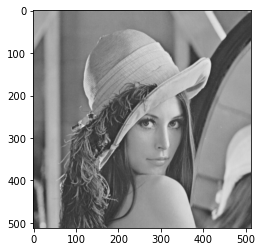

In [2]:
img = cv2.imread('F:/ACADEMIC/lena.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
width = int(img.shape[1]*0.3)
height = int(img.shape[0]*0.3)
dim = (width, height)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

img.shape

(153, 153)

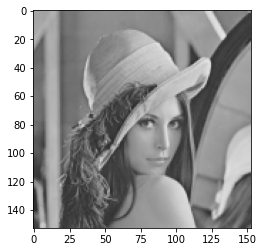

In [4]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [28]:
import numpy as np

kernel = np.array(([0,-1,0],[-1,5,-1],[0,-1,0]), np.float32)

kernel_row, kernel_col = kernel.shape
img_row, img_col = img.shape
result_row = kernel_row + img_row - 1
result_col = kernel_col + img_col - 1
(result_row, result_col)

(155, 155)

In [29]:
padded_kernel = np.pad(kernel, ((result_row-kernel_row,0),(0,result_col-kernel_col)),
                'constant', constant_values=0)
padded_kernel

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  5., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [44]:
from scipy.linalg import toeplitz

toeplitz_filter = []

for i in range(padded_kernel.shape[0]-1, -1, -1):
    ith_row = padded_kernel[i, :]
    row = np.r_[ith_row[0], np.zeros(img_col-1,dtype="float32" )]
    
    toeplitz_mat = toeplitz(ith_row, row)
    toeplitz_filter.append(toeplitz_mat)


In [31]:
#doubly blocked
c = range(1, padded_kernel.shape[0]+1)
r = np.r_[c[0], np.zeros(img_row-1, dtype=int)]
doubly_mat = toeplitz(c,r)
doubly_mat

array([[  1,   0,   0, ...,   0,   0,   0],
       [  2,   1,   0, ...,   0,   0,   0],
       [  3,   2,   1, ...,   0,   0,   0],
       ...,
       [153, 152, 151, ...,   3,   2,   1],
       [154, 153, 152, ...,   4,   3,   2],
       [155, 154, 153, ...,   5,   4,   3]])

In [32]:
toeplitz_shape = toeplitz_filter[0].shape
height = toeplitz_shape[0]*doubly_mat.shape[0]
width = toeplitz_shape[1]*doubly_mat.shape[1]

doubly_blocked_shape = [height, width]
doubly_blocked_mat = np.zeros(doubly_blocked_shape, dtype="float32")


In [33]:
b_h, b_w = toeplitz_shape # hight and withs of each block
for i in range(doubly_mat.shape[0]):
    for j in range(doubly_mat.shape[1]):
        start_i = i * b_h
        start_j = j * b_w
        end_i = start_i + b_h
        end_j = start_j + b_w
        doubly_blocked_mat[start_i: end_i, start_j:end_j] = toeplitz_filter[doubly_mat[i,j]-1]



In [34]:
doubly_blocked_mat


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [35]:
def mat_to_vectr(inp):
    inp_h, inp_w = inp.shape
    output = np.zeros(inp_h*inp_w, dtype=inp.dtype)
    
    inp = np.flipud(inp)
    for i, row in enumerate(inp):
        start = i*inp_w
        end = start+inp_w
        output  [start:end]=row
    return output

In [36]:
img_vect = mat_to_vectr(img)
img_vect

array([ 57,  61,  63, ..., 140, 174, 160], dtype=uint8)

In [37]:
result = np.matmul(doubly_blocked_mat, img_vect) 
result

array([   0.,  -57.,  -61., ..., -174., -160.,    0.], dtype=float32)

In [38]:
def vector_to_matrix(inpt, output_shape):
    output_h, output_w = output_shape
    output = np.zeros(output_shape, dtype=inpt.dtype)
    for i in range(output_h):
        st = i*output_w
        nd = st + output_w
        output[i, :] = inpt[st:nd]
    output=np.flipud(output)
    return output

In [39]:
result_img_shape = [result_row, result_col]
result_img = vector_to_matrix(result, result_img_shape)

In [40]:
#result_img.shape
type(result_img)


numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


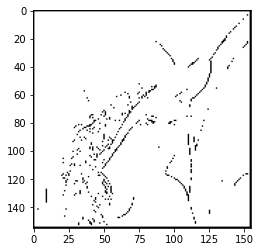

In [43]:
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.show()